In [1]:
import pandas as pd
df = pd.read_csv("All_letters.csv", encoding="latin-1", header=None)
print(df.head())

  0     1     2     3     4     5     6     7     8     9     ...  1592  1593  \
0    a     0     0     0     0     0     0     0     0     0  ...     0     0   
1    a     0     0     0     0     0     0     0     0     0  ...     0     0   
2    a     0     0     0     0     0     0     0     0     0  ...     0     0   
3    a     0     0     0     0     0     0     0     0     0  ...     0     0   
4    a     0     0     0     0     0     0     0     0     0  ...     0     0   

   1594  1595  1596  1597  1598  1599  1600  1601  
0     0     0     0     0     0     0     0   NaN  
1     0     0     0     0     0     0     0   NaN  
2     0     0     0     0     0     0     0   NaN  
3     0     0     0     0     0     0     0   NaN  
4     0     0     0     0     0     0     0   NaN  

[5 rows x 1602 columns]


[[<AxesSubplot:title={'center':'1'}>]]


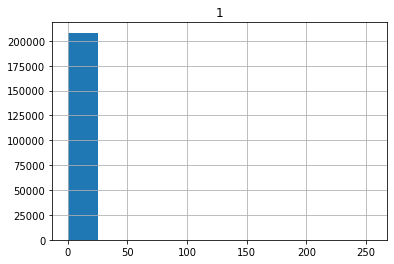

In [6]:
print(df.hist(column=[1]))

First we define some global variables which are used for the whole training process

In [5]:
# Change the paths accordingly
path_train_csv = "train.csv"
path_test_csv = "test.csv"
# First we have to select the classes on which we would like to train on
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
# All available classes
#classes = ['!','$','&','(',')','+','0','1','2','3','4','5','6','7','8','9','<','>','?','A','B','C','D','E','F','G','H',
#           'I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','a','b','c','d','e','f','g','h','i',
#           'j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','~','ß','α','β','π','φ','€','∑','√','∞',
#           '∫']
num_classes = len(classes)

# Standard DL-parameters
batch_size = 16
num_workers = 12
hparams = {"num_epochs": 100, "early_stopping_patience": 5, "early_stopping_threshold": 0.001}

For training later on we need to generate a one_hot_encoding

In [6]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
reshaped_classes = np.array(classes).reshape(-1, 1)
onehot_encoder = onehot_encoder.fit(reshaped_classes)

Now we define a simple CNN-model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PyTorchClassifier(nn.Module):
    def __init__(self, num_classes):
        super(PyTorchClassifier, self).__init__()
        self.size_fc1 = 256
        self.conv1 = nn.Conv2d(1, 32, 6)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 4)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 256, 2)
        self.fc1 = nn.Linear(self.size_fc1, 256)
        #self.fc2 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
from tqdm import tqdm


def train_model(data_loaders, model, loss_func, optimizer, device):
    print("training started")
    num_epochs = hparams["num_epochs"]
    best_model_wts = copy.deepcopy(model.state_dict())
    lr = optimizer.param_groups[0]["lr"]
    information = EpochInformation(model, device, num_classes, dataset_sizes)
    early_stopper = EarlyStopper(patience=hparams["early_stopping_patience"],
                             min_delta=hparams["early_stopping_threshold"],
                             model_weights=copy.deepcopy(model.state_dict()))

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        if stop == True:
            break
            # Each epoch has a training and validation phase
        for phase in ['val', 'train']:
            lr = optimizer.param_groups[0]["lr"]
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode
            information.reset_metrics()
            # Iterate over data.
            data_loader = tqdm(data_loaders[phase])
            for inputs, labels in data_loader:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = loss_func(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                information.update_metrics_for_batch(outputs, loss, inputs, labels)

            result_dict = information.calculate_metrics(phase)
            # prints the all metrics of the training and validation phase
            print(" ".join(name + ": " + str(round(value, 4)) for name, value in result_dict.items()))

            if phase == 'val':
                if early_stopper.early_stop(result_dict["mcc"], copy.deepcopy(model.state_dict())):
                    print('early stopping')
                    stop = True
    # load best model weights
    model.load_state_dict(early_stopper.best_model_weights)
    # model.load_state_dict(best_model_wts)
    return model


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((224, 224), antialias=True),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
     #transforms.Normalize(35.37502147246886, 75.87412766890324)])

train_set = GermanCharacterRecognitionDS(path_train_csv, transform=transform, classes=classes,
                                         one_hot_encoder=onehot_encoder, num_channels=3)
test_set = GermanCharacterRecognitionDS(path_test_csv, transform=None, classes=classes,
                                        one_hot_encoder=onehot_encoder, num_channels=3)

#train_loader, val_loader = get_train_and_val_loader(train_set, 250, onehot_encoder, classes)
train_loader, val_loader = split_train_loader(train_set, np.load("train_indices_digits.npy"),
                                              np.load("val_indices_digits.npy"))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
print("train_loader: " + str(get_all_labels_of_data_loader(train_loader, onehot_encoder)))
print("val_loader: " + str(get_all_labels_of_data_loader(val_loader, onehot_encoder)))
print("test_loader: " + str(get_all_labels_of_data_loader(test_loader, onehot_encoder)))

data_loaders = {"train": train_loader, "val": val_loader}
dataset_sizes = {"train": len(train_loader.dataset), "val": len(val_loader.dataset)}
#model = network_pytorch.PyTorchClassifier(len(classes))
loss_func = torch.nn.CrossEntropyLoss()

NameError: name 'transforms' is not defined